# Demo model on real data

In [42]:
# import libraries
from tensorflow.keras import models, preprocessing
from tensorflow.keras.preprocessing import image
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# create path to data
demo = os.path.dirname(os.getcwd()) + '\\data\\test\\processed\\'

In [36]:
# set parameters for the model
batch_size = 32
img_height = 558
img_width = 558

In [37]:
# create a variable to contain the normalizer
demo_datagen = image.ImageDataGenerator(rescale=1/255.)

# normalize the demo data
demo_ds = demo_datagen.flow_from_directory(
                        demo,
                        target_size = (img_height, img_width),
                        classes = None,
                        class_mode=None,
                        shuffle=False)

Found 521 images belonging to 1 classes.


In [38]:
# write out the demo data filenames
demo_ds_fp = demo_ds.filenames

In [2]:
# load the model
model1 = models.load_model('saved_models/model-01/')

In [39]:
# write out the demo predictions
demo_predictions1 = model1.predict(demo_ds)

In [40]:
pred_df = pd.DataFrame({'filepath': demo_ds_fp, 'predictions': demo_predictions[:,0]})

In [45]:
pred_df[pred_df['predictions'] >= 0.5]

,filepath,predictions
59,demo\IMAG0009-375-3553-7854.jpg,0.652692
78,demo\IMAG0009-375-3927-7667.jpg,0.596339
232,demo\IMAG0009-553-2760-6624.jpg,0.754186
238,demo\IMAG0009-553-3312-828.jpg,0.896909
244,demo\IMAG0009-553-3864-5520.jpg,0.799850
297,demo\IMAG0009-813-2436-812.jpg,0.800736
303,demo\IMAG0009-813-3654-6090.jpg,0.783355
304,demo\IMAG0009-813-3654-812.jpg,0.914786
322,demo\IMAG0009-813-812-6090.jpg,0.719680
391,demo\IMAG0030-469-5616-4914.jpg,0.637375


In [43]:
pred_df[pred_df['filepath'].str.contains('IMAG0009-375-3927-7667')]

,filepath,predictions
78,demo\IMAG0009-375-3927-7667.jpg,0.596339


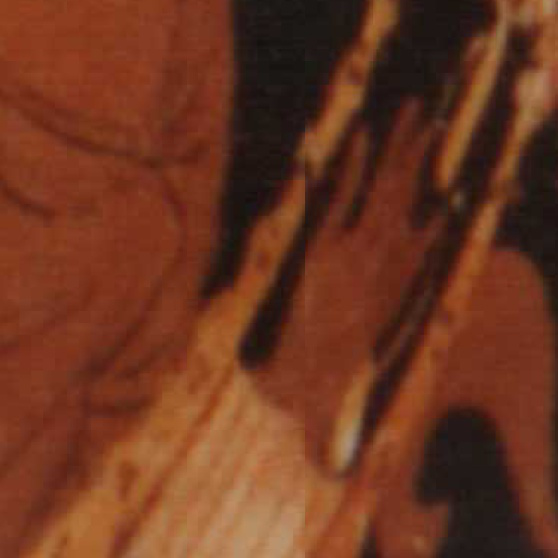

In [44]:
Image.open(demo + 'demo\IMAG0009-375-3927-7667.jpg')